#### _Librerías necesarias_

In [237]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

---
# **Ejercicio 1: Correlación**

#### Inciso A

In [238]:
def extraer_pares_verticales(imagen):
    height, width = imagen.shape
    pares = []
    for i in range(0, height - 1, 2):
        for j in range(width):
            pixel_superior = imagen[i, j]
            pixel_inferior = imagen[i + 1, j]
            pares.append([pixel_superior, pixel_inferior])
    return np.array(pares)

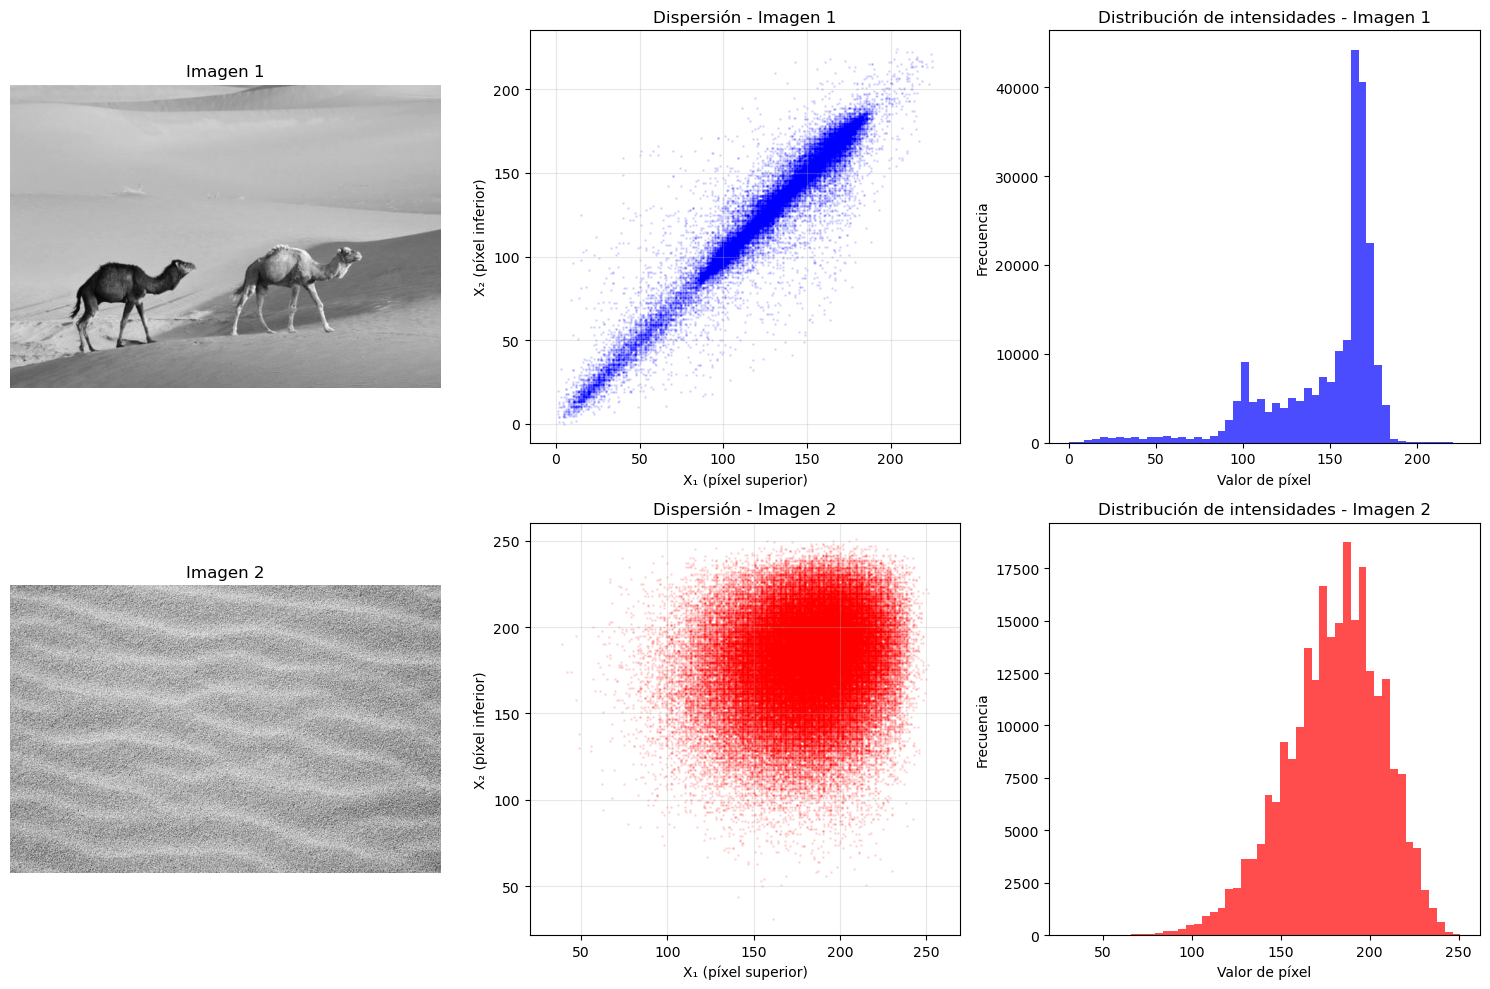

In [239]:
# Cargar las imágenes y convertirlas a escala de grises y float
img1 = np.array(Image.open('imagenes/img_01.jpg').convert('L')).astype(float)
img2 = np.array(Image.open('imagenes/img_02.jpg').convert('L')).astype(float)

# Extraer pares para ambas imágenes
pares_img1 = extraer_pares_verticales(img1)
pares_img2 = extraer_pares_verticales(img2)

# Crear la figura con subplots
plt.figure(figsize=(15, 10))

# Mostrar imagen 1
plt.subplot(2, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('Imagen 1')
plt.axis('off')

# Scatter plot para imagen 1
plt.subplot(2, 3, 2)
plt.scatter(pares_img1[:, 0], pares_img1[:, 1], alpha=0.1, s=1, color='blue')
plt.title('Dispersión - Imagen 1')
plt.xlabel('X₁ (píxel superior)')
plt.ylabel('X₂ (píxel inferior)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Histograma marginal para imagen 1
plt.subplot(2, 3, 3)
plt.hist(pares_img1.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Distribución de intensidades - Imagen 1')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Mostrar imagen 2
plt.subplot(2, 3, 4)
plt.imshow(img2, cmap='gray')
plt.title('Imagen 2')
plt.axis('off')

# Scatter plot para imagen 2
plt.subplot(2, 3, 5)
plt.scatter(pares_img2[:, 0], pares_img2[:, 1], alpha=0.1, s=1, color='red')
plt.title('Dispersión - Imagen 2')
plt.xlabel('X₁ (píxel superior)')
plt.ylabel('X₂ (píxel inferior)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Histograma marginal para imagen 2
plt.subplot(2, 3, 6)
plt.hist(pares_img2.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Distribución de intensidades - Imagen 2')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Información adicional útil
# print(f"Dimensiones Imagen 1: {img1.shape}")
# print(f"Dimensiones Imagen 2: {img2.shape}")
# print(f"Número de pares verticales Imagen 1: {len(pares_img1)}")
# print(f"Número de pares verticales Imagen 2: {len(pares_img2)}")
# print(f"Rango de valores Imagen 1: [{img1.min():.1f}, {img1.max():.1f}]")
# print(f"Rango de valores Imagen 2: [{img2.min():.1f}, {img2.max():.1f}]")

#### Inciso B

In [240]:
def correlacion(pares):
    X1 = pares[:,0] # Extraer primera columna -> píxel de arriba
    X2 = pares[:,1] # Extraer segunda columna -> píxel de abajo
    return np.corrcoef(X1, X2)[0,1] # Armar la matriz de correlación 2x2 y agarrar la correlación entre X1 y X2

corr_img1 = correlacion(pares_img1)
corr_img2 = correlacion(pares_img2)

print(f"Coeficiente de correlación Imagen 1: {corr_img1:.4f}")
print(f"Coeficiente de correlación Imagen 2: {corr_img2:.4f}")

Coeficiente de correlación Imagen 1: 0.9792
Coeficiente de correlación Imagen 2: 0.1459


#### Inciso C

In [241]:
def transformar_pca(pares):
    pca = PCA(n_components=2) # Aplicar PCA para desacoplar las variables de cada vector
    return pca.fit_transform(pares)

# Transformar los pares de ambas imágenes
pares_img1_pca = transformar_pca(pares_img1)
pares_img2_pca = transformar_pca(pares_img2)


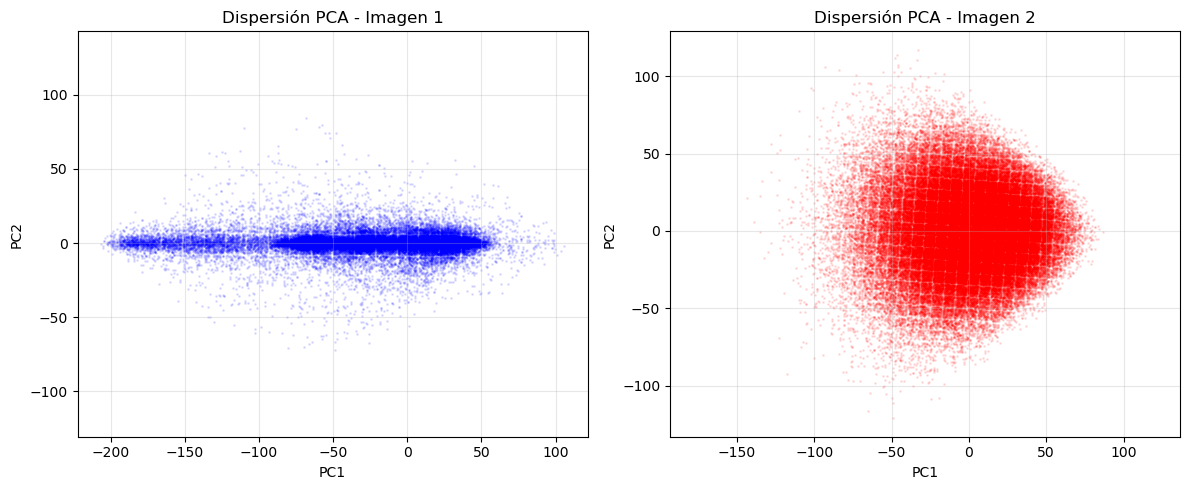

In [242]:
# Graficar dispersión de los vectores transformados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pares_img1_pca[:, 0], pares_img1_pca[:, 1], alpha=0.1, s=1, color='blue')
plt.title('Dispersión PCA - Imagen 1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(pares_img2_pca[:, 0], pares_img2_pca[:, 1], alpha=0.1, s=1, color='red')
plt.title('Dispersión PCA - Imagen 2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# **Ejercicio 2: Compresión**

#### Inciso A - Implementación _PCA_transform()_

In [243]:
def our_svd(x: np.array, n_samples: int):
    cov = (x.T @ x) / (n_samples - 1)

    # Calculamos autovalores y autovectores de la matriz de covarianza. Después los ordenamos de mayor a menor
    autovalues, V = np.linalg.eigh(cov)

    idx = np.argsort(autovalues)[::-1]
    autovalues = autovalues[idx]
    V = V[:, idx]

    # Calculamos los valores singulares en base a su relación teórica con los autovalores de la matriz de cov
    S = np.sqrt(autovalues*(n_samples - 1))

    # Calculamos U (teniendo cuidado con no dividir por cero porque sino revienta)
    nonzero_idx = S > 1e-10
    U = (x @ V[:, nonzero_idx]) @ np.linalg.inv(np.diag(S[nonzero_idx]))

    return U, S, V, autovalues

def pca_transform(x: int, saving: float, graphic: int = 0):
    n_samples, m = x.shape

    # 1. Centramos los datos utilizando el vector de medias muestrales
    mu = np.mean(x, axis=0)
    x = x - mu[None, :]

    # 2. Hacemos SVD (Nosotros decidimos implementarlo de cero, aunque puede usarse numpy.linalg.svd) [ATENCIÓN] Si se elige utilizar np.linalg.svd hay que tener en cuenta
    # que numpy devuelve V transpuesta, por lo que para usar PCA debemos transponer U, S, V = np.linalg.svd(x), V = V.T
    U, S, V, autovalues = our_svd(x, n_samples)
    
    # 3. Determinar k para lograr el ahorro deseado (Space Saving)
    k = int(m * (1 - saving) + 0.5)
    if k < 1:k = 1
    if k > m: k = m

    # 4. Proyectar a k dimensiones
    V_k = V[:, :k]
    x_compressed = x @ V_k

    if (graphic): # Graficar autovalores (usamos también escala logaritmica para poder visualizar mejor los datos)
        colors = ['blue' if i < k else 'red' for i in range(len(autovalues))]

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Escala normal
        axes[0].bar(range(1, len(autovalues) + 1), autovalues, color=colors)
        axes[0].axvline(k + 0.5, color='green', linestyle='--', label=f'S={saving*100:.0f}% (k={k})')
        axes[0].set_xlabel('Componente principal')
        axes[0].set_ylabel('Autovalor')
        axes[0].set_title('Escala normal')
        axes[0].legend()

        # Escala logarítmica
        axes[1].bar(range(1, len(autovalues) + 1), autovalues, color=colors)
        axes[1].axvline(k + 0.5, color='green', linestyle='--', label=f'S={saving*100:.0f}% (k={k})')
        axes[1].set_yscale('log')
        axes[1].set_xlabel('Componente principal')
        axes[1].set_ylabel('Autovalor')
        axes[1].set_title('Escala logarítmica')
        axes[1].legend()

        plt.tight_layout()
        plt.show()


    return x_compressed, V_k, mu

#### Inciso B - Preparación y utilización de PCA

In [244]:
def cut_img(img:np.array, n:int = 8) -> np.array:
    h, w = img.shape

    #Recortamos la imagen para que sea divisible en cuadrados de nxn
    h_cut = h - (h % n)
    w_cut = w - (w % n)

    #Dividimos a la mitad nuestro sobrante para eliminar de forma centrada el excedente (para evitar sesgos)
    start_h = (h - h_cut) // 2
    start_w = (w - w_cut) // 2

    return img[start_h:(start_h+h_cut), start_w:(start_w+w_cut)], h_cut, w_cut

def n_segmentation_img (img:np.array, h: int, w: int, n: int = 8) -> np.array:
    img_seg = []

    for i in range(0, h, n):
        for j in range(0, w, n):
                img_seg.append(img[i:(i+n), j:(j+n)].flatten(order="F")) # Tomamos un cuadrado nxn y lo aplanamos por columnas

    return np.array(img_seg)

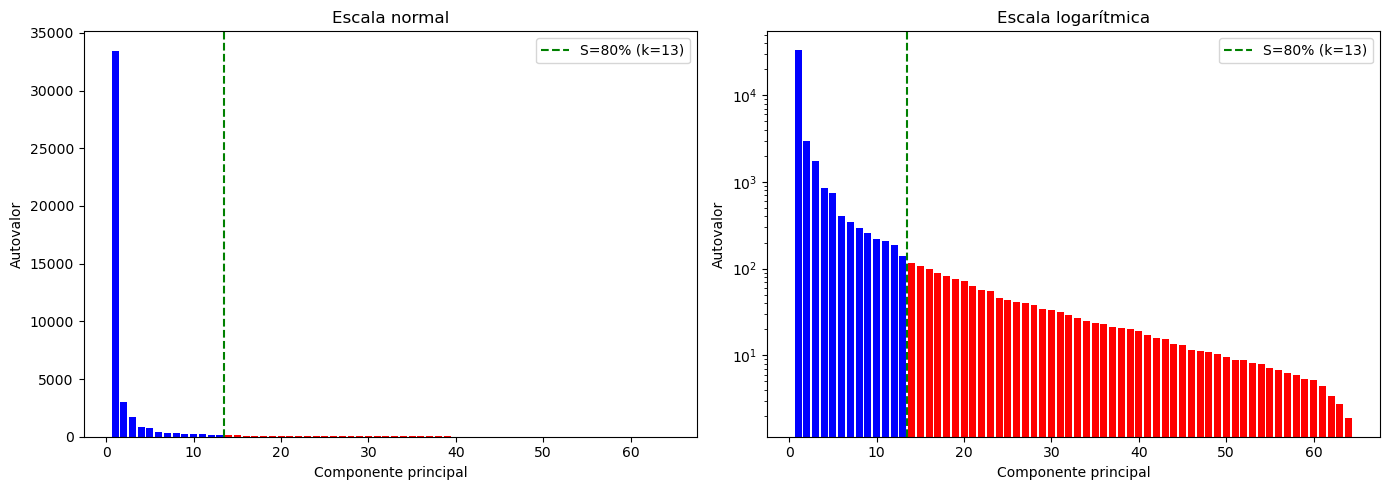

In [245]:
img = np.array(Image.open('imagenes/img_03.jpg').convert('L')).astype(float)
img, h, w = cut_img(img)

x = n_segmentation_img(img, h, w)

x_compressed, Vk, mu = pca_transform(x, 0.8, 1);

---
# **Ejercicio 3: Descompresión**

#### Inciso A - Imprementación de la descompresión

In [246]:
def decompress_image(x_compressed: np.array, V_k, mu, h: int, w: int, n_seg = 8):
    x_reconstructed = x_compressed @ V_k.T + mu[None, :]
    
    img_reconstructed = np.zeros((h, w)) # Primero creamos la imagen vacía
    
    # Reorganizar bloques
    n_rows = h // n_seg
    n_cols = w // n_seg
    idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            block = x_reconstructed[idx].reshape((n_seg, n_seg), order="F")
            img_reconstructed[i*n_seg:(i+1)*n_seg, j*n_seg:(j+1)*n_seg] = block
            idx += 1
    
    return img_reconstructed

#### Inciso B - Comparación con la original

In [247]:
def plot_image_comparison(img_original, img_reconstructed):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title('Imagen Reconstruida')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

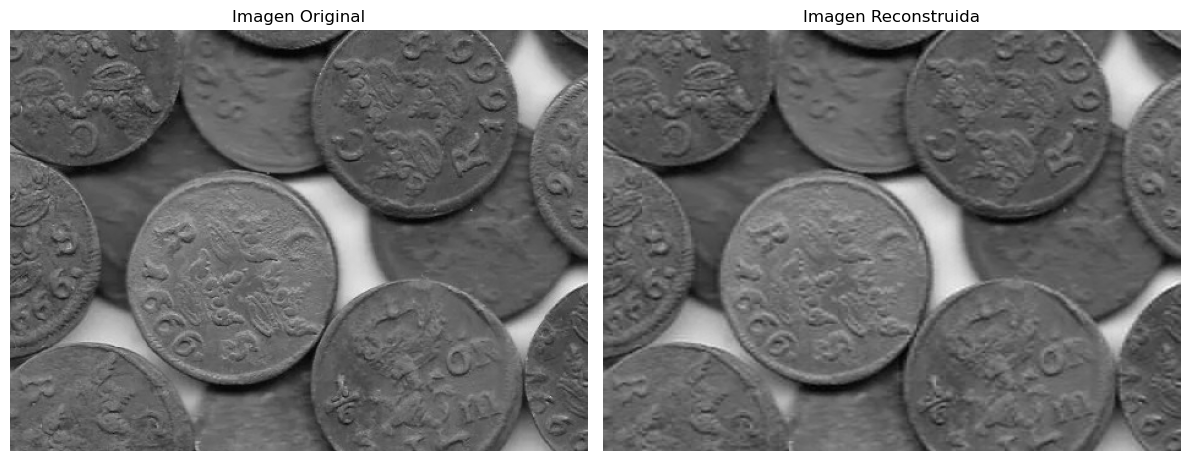

In [248]:
img_reconstructed = decompress_image(x_compressed, Vk, mu, h, w)
plot_image_comparison(img, img_reconstructed)

---
# **Ejercicio 4: Medidas de Desempeño**

#### Inciso A - Calcular y graficar MSE

In [249]:
def calculate_MSE(x, S_values, h, w):
    mse_results = []

    for s in S_values:
        x_compressed, V_k, mu = pca_transform(x, s)
        
        img_reconstructed = decompress_image(x_compressed, V_k, mu, h, w)
        
        # Calcular y guardar el MSE
        mse = np.mean((img - img_reconstructed) ** 2)
        mse_results.append(mse)
    
    return mse_results

def plot_MSEvsS(mse_results, S_values):
    plt.figure(figsize=(10, 6))
    plt.plot([s * 100 for s in S_values], mse_results, marker='o', linestyle='-')
    plt.title('MSE vs. Ahorro de Espacio (S) - Compresión por Bloques')
    plt.xlabel('Espacio Ahorrado S (%)')
    plt.ylabel('Error Cuadrático Medio (MSE)')
    plt.grid(True)
    plt.show()

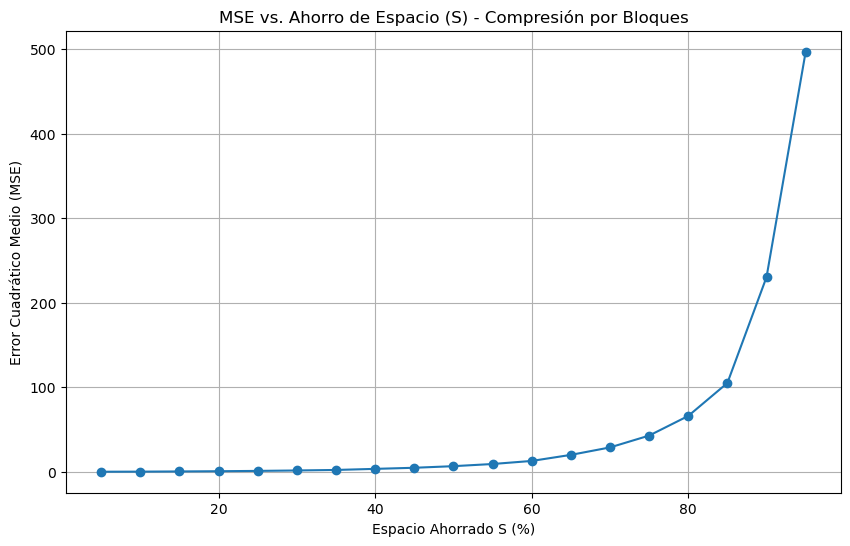

In [250]:
img = np.array(Image.open('imagenes/img_04.jpg').convert('L')).astype(float)
img, h ,w = cut_img(img)

x = n_segmentation_img(img, h, w)

S_values = [5 * n / 100.0 for n in range(1, 20)]

mse = calculate_MSE(x, S_values, h, w)
plot_MSEvsS(mse, S_values)

#### Inciso B - Gráfico original vs comprimidas

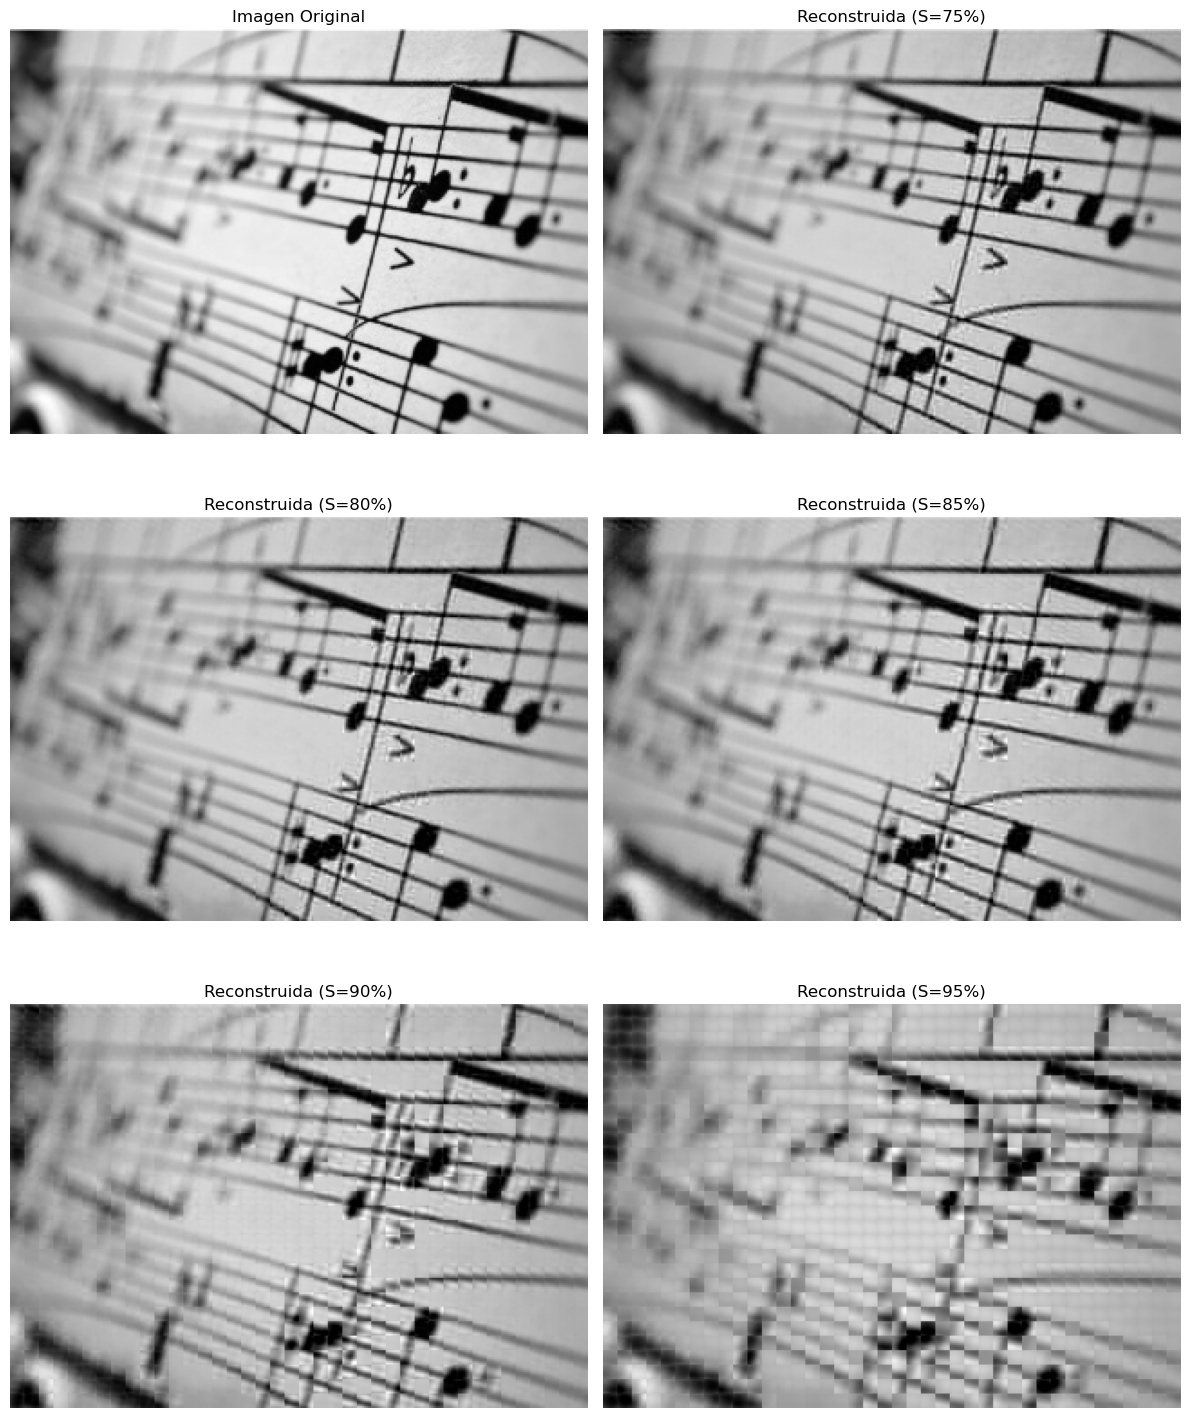

In [253]:
# Cantidad total de imágenes: original + reconstruidas
n_images = 1 + len(S_values[14:])

# Dos columnas siempre, filas calculadas
ncols = 2
nrows = math.ceil(n_images / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))

# Asegurarse de trabajar con axes como un array plano
axes = axes.ravel()

# Imagen original
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

# Reconstrucciones
for i, s in enumerate(S_values[14:]):
    x_compressed, V_k, mu = pca_transform(x, s)
    img_reconstructed = decompress_image(x_compressed, V_k, mu, h, w)

    axes[i + 1].imshow(img_reconstructed, cmap='gray', vmin=0, vmax=255)
    axes[i + 1].set_title(f'Reconstruida (S={int(s*100)}%)')
    axes[i + 1].axis('off')

# Si sobran subplots vacíos, los ocultamos
for j in range(n_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
